<a href="https://colab.research.google.com/github/Bint7bara/KerasEvaluateModule/blob/master/ensemble_keras_binary_classifier_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install  tensorflow_decision_forests==0.2.5
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_decision_forests as tfdf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.8 MB 50 kB/s 


In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [4]:
seed = 7

# load pima indians dataset
dataset = np.loadtxt("NewGencode4DLTraining2.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:12]
Y = dataset[:,12]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, 
    test_size=0.2, random_state=42
)
X_train,y_train

(array([[ 2.69465671e-05,  1.36104279e-06,  8.57400000e-01, ...,
          5.40386800e-02, -5.42105263e-01,  1.31400000e+03],
        [ 2.02332789e-04,  1.18597914e-07,  1.28090000e+00, ...,
          1.02175970e-01, -3.40088106e-01,  6.84000000e+02],
        [ 5.49928044e-06,  3.14581615e-05,  5.23900000e-01, ...,
          4.72553700e-02, -2.36842105e-01,  2.31000000e+02],
        ...,
        [ 3.39736457e-07,  4.06913407e-07,  1.23220000e+00, ...,
          7.06860710e-02, -3.11538462e-01,  3.15000000e+02],
        [ 2.04195878e-05,  6.72560437e-05,  9.38900000e-01, ...,
          1.00467290e-01, -1.06481482e+00,  1.65000000e+02],
        [ 4.55885483e-06,  3.10816341e-06,  1.10460000e+00, ...,
          1.12017804e-01,  1.83272727e-01,  8.28000000e+02]]),
 array([1., 1., 0., ..., 0., 1., 1.]))

In [6]:
# Input features.
num_features = 12
raw_features = tf.keras.layers.Input(shape=(num_features,))

# Stage 1
# =======

# Common learnable pre-processing
preprocessor = tf.keras.layers.Dense(10, activation=tf.nn.relu6)
preprocess_features = preprocessor(raw_features)

# Stage 2
# =======

# Model #1: NN
m1_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m1_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m1_z1)

# Model #2: NN
m2_z1 = tf.keras.layers.Dense(5, activation=tf.nn.relu6)(preprocess_features)
m2_pred = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(m2_z1)


# Model #3: DF
model_3 = tfdf.keras.RandomForestModel(num_trees=1000, random_seed=1234)
m3_pred = model_3(preprocess_features)

# Model #4: DF
model_4 = tfdf.keras.RandomForestModel(
    num_trees=1000,
    #split_axis="SPARSE_OBLIQUE", # Uncomment this line to increase the quality of this model
    random_seed=4567)
m4_pred = model_4(preprocess_features)

# Since TF-DF uses deterministic learning algorithms, you should set the model's
# training seed to different values otherwise both
# `tfdf.keras.RandomForestModel` will be exactly the same.

# Stage 3
# =======

mean_nn_only = tf.reduce_mean(tf.stack([m1_pred, m2_pred], axis=0), axis=0)
mean_nn_and_df = tf.reduce_mean(
    tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)

# Keras Models
# ============

ensemble_nn_only = tf.keras.models.Model(raw_features, mean_nn_only)
ensemble_nn_and_df = tf.keras.models.Model(raw_features, mean_nn_and_df)

Use /tmp/tmph6x19rf6 as temporary training directory


Use /tmp/tmpn4d0xv5y as temporary training directory


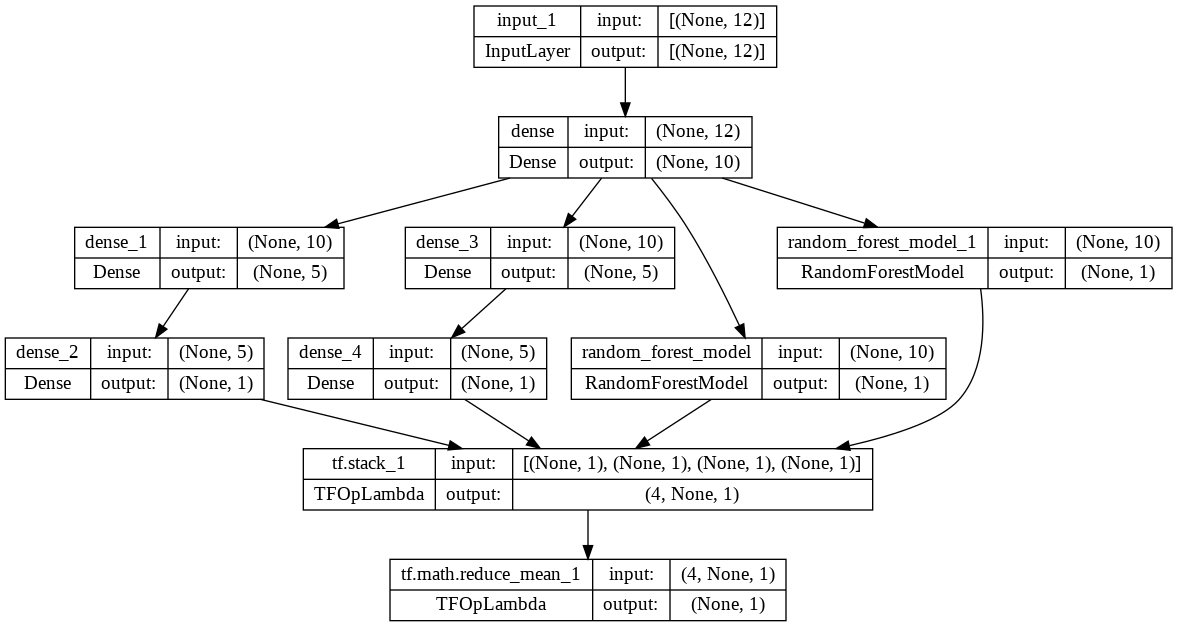

In [7]:
from keras.utils.vis_utils import plot_model

plot_model(ensemble_nn_and_df, to_file="/tmp/model.png", show_shapes=True)

In [8]:
%%time
ensemble_nn_only.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])

ensemble_nn_only.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test),
)

Epoch 1/100
345/345 [==============================] - 2s 3ms/step - loss: 0.4923 - accuracy: 0.8187 - val_loss: 0.4575 - val_accuracy: 0.8381
Epoch 2/100
345/345 [==============================] - 1s 2ms/step - loss: 0.4434 - accuracy: 0.8380 - val_loss: 0.4345 - val_accuracy: 0.8390
Epoch 3/100
345/345 [==============================] - 1s 2ms/step - loss: 0.4263 - accuracy: 0.8403 - val_loss: 0.4241 - val_accuracy: 0.8377
Epoch 4/100
345/345 [==============================] - 1s 2ms/step - loss: 0.4164 - accuracy: 0.8424 - val_loss: 0.4163 - val_accuracy: 0.8432
Epoch 5/100
345/345 [==============================] - 1s 3ms/step - loss: 0.4103 - accuracy: 0.8449 - val_loss: 0.4112 - val_accuracy: 0.8392
Epoch 6/100
345/345 [==============================] - 1s 3ms/step - loss: 0.4040 - accuracy: 0.8466 - val_loss: 0.4076 - val_accuracy: 0.8459
Epoch 7/100
345/345 [==============================] - 1s 3ms/step - loss: 0.4019 - accuracy: 0.8505 - val_loss: 0.4040 - val_accuracy: 0.8399

In [9]:
evaluation_nn_only = ensemble_nn_only.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", evaluation_nn_only)

87/87 [==============================] - 0s 2ms/step - loss: 0.2505 - accuracy: 0.9032
test loss, test acc: [0.25046414136886597, 0.9031731486320496]


In [11]:
model_3.compile(["accuracy"])
model_4.compile(["accuracy"])


In [15]:
model_3.fit(X_train,y_train)
model_4.fit(X_train,y_train)


Reading training dataset...
Training dataset read in 0:00:00.176310. Found 22056 examples.
Training model...
Model trained in 0:00:56.680677
Compiling model...
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.195192. Found 22056 examples.
Training model...
Model trained in 0:00:56.674637
Compiling model...
Model compiled.


In [16]:
evaluation_df3_only = model_3.evaluate(
    X_test, y_test, return_dict=True)
evaluation_df4_only = model_4.evaluate(
    X_test,y_test, return_dict=True)


173/173 [==============================] - 2s 9ms/step - loss: 0.0000e+00 - accuracy: 0.9478


In [17]:
print("Accuracy (DF #3 only): ", evaluation_df3_only["accuracy"])
print("Accuracy (DF #4 only): ", evaluation_df4_only["accuracy"])

Accuracy (DF #3 only):  0.9490480422973633
Accuracy (DF #4 only):  0.9477787613868713


In [18]:
ensemble_nn_and_df.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])


evaluation_nn_and_df = ensemble_nn_and_df.evaluate(X_test)

print("Accuracy (2xNN and 2xDF): ", evaluation_nn_and_df["accuracy"])
print("Loss (2xNN and 2xDF): ", evaluation_nn_and_df["loss"])

Exception: ignored

In [28]:
mean_df_only = tf.reduce_mean(tf.stack([m3_pred, m4_pred], axis=0), axis=0)
# mean_nn_and_df = tf.reduce_mean(
#    tf.stack([m1_pred, m2_pred, m3_pred, m4_pred], axis=0), axis=0)

# Keras Models
# ============

ensemble_df_only = tf.keras.models.Model(raw_features, mean_nn_only)
#ensemble_nn_and_df = tf.keras.models.Model(raw_features, mean_nn_and_df)

In [30]:
%%time
ensemble_df_only.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=["accuracy"])


CPU times: user 8.38 ms, sys: 1.03 ms, total: 9.41 ms
Wall time: 11.7 ms


In [32]:
ensemble_df_only.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test),
)

Epoch 1/100
345/345 [==============================] - 3s 7ms/step - loss: 0.2464 - accuracy: 0.9056 - val_loss: 0.2536 - val_accuracy: 0.9039
Epoch 2/100
345/345 [==============================] - 3s 9ms/step - loss: 0.2475 - accuracy: 0.9048 - val_loss: 0.2543 - val_accuracy: 0.9012
Epoch 3/100
345/345 [==============================] - 2s 6ms/step - loss: 0.2477 - accuracy: 0.9041 - val_loss: 0.2628 - val_accuracy: 0.8961
Epoch 4/100
345/345 [==============================] - 2s 6ms/step - loss: 0.2484 - accuracy: 0.9036 - val_loss: 0.2504 - val_accuracy: 0.9012
Epoch 5/100
345/345 [==============================] - 2s 6ms/step - loss: 0.2462 - accuracy: 0.9050 - val_loss: 0.2508 - val_accuracy: 0.9019
Epoch 6/100
345/345 [==============================] - 2s 6ms/step - loss: 0.2461 - accuracy: 0.9051 - val_loss: 0.2472 - val_accuracy: 0.9050
Epoch 7/100
345/345 [==============================] - 2s 6ms/step - loss: 0.2483 - accuracy: 0.9049 - val_loss: 0.2479 - val_accuracy: 0.9050

In [37]:
#ensemble_nn_and_df.compile(
#    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])


evaluation_df_only = ensemble_df_only.evaluate(X_test)

#print("Accuracy (2xNN and 2xDF): ", evaluation_df_only["accuracy"])
#print("Loss (2xNN and 2xDF): ", evaluation_df_only["loss"])

173/173 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
